<a href="https://colab.research.google.com/github/fosfrancesco/pitch-spelling/blob/main/pitch_spelling_rnncrf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade pytorch-crf

Requirement already up-to-date: pytorch-crf in /usr/local/lib/python3.6/dist-packages (0.7.2)


In [ ]:
import music21 as m21
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import pickle
from google.colab import files

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn
import music21 as m21
from collections import Counter

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF
import torchtext
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm, tqdm_notebook, notebook
from google.colab import files
import pickle

from sklearn.metrics import accuracy_score

import time

from collections import defaultdict, Counter
# import optuna

# RNN for Pitch Spelling

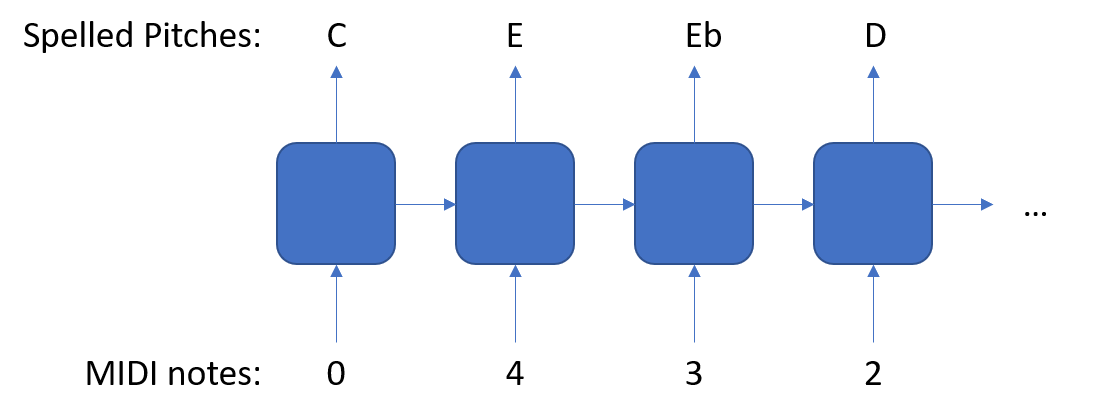

Dataset: different authors from MuseData collection
Challenges:
- extremely long sequences
- small dataset

In [ ]:
pitches_dict = {
    0 : ["C","B#","D--"], # nn.Linear(input_size+context_size, 3)
    1 : ["C#","B##","D-"], # nn.Linear(input_size+context_size, 2)
    2 : ["D","C##","E--"], # nn.Linear(input_size+context_size, 3)
    3 : ["D#","E-","F--"],
    4 : ["E","D##","F-"],
    5 : ["F","E#","G--"],
    6 : ["F#","E##","G-"],
    7 : ["G","F##","A--"],
    8 : ["G#","A-"],
    9 : ["A","G##","B--"],
    10 : ["A#","B-","C--"],
    11 : ["B","A##","C-"]
}

accepted_pitches = [ii for i in pitches_dict.values() for ii in i]
print([e for e in enumerate(accepted_pitches)])

double_acc_pitches = [ii for i in pitches_dict.values() for ii in i if ii.endswith("##") or  ii.endswith("--") ]
print(double_acc_pitches)

def score2midi_numbers(score):
  return [p.midi%12 for n in score.flat.notes for p in n.pitches]

def score2pitches(score):
  return [p.name for n in score.flat.notes for p in n.pitches]

interval_dict = {
    0 : ["P1","d2","A7"], 
    1 : ["m2","A1"], 
    2 : ["M2","d3","AA1"], 
    3 : ["m3","A2"],
    4 : ["M3","d4","AA2"],
    5 : ["P4","A3"],
    6 : ["d5","A4"],
    7 : ["P5","d6","AA4"],
    8 : ["m6","A5"],
    9 : ["M6","d7","AA5"],
    10 : ["m7","A6"],
    11 : ["M7","d1","AA6"]
}

accepted_intervals = [ii for i in interval_dict.values() for ii in i]
print([e for e in enumerate(accepted_intervals)])

def transp_score(score):
    """ For each input return len(accepted_intervals) transposed scores"""
    return [score.transpose(interval) for interval in accepted_intervals]

def smart_transp_score(score):
    """ For each chromatic interval chose the interval that lead to the smallest number of accidentals"""
    scores = []
    for chromatic_int in interval_dict.keys():
        temp_scores = []
        temp_acc_number = []
        for diat_interval in interval_dict[chromatic_int]:
            new_score = score.transpose(diat_interval)
            temp_scores.append(new_score)
            temp_acc_number.append(sum([pitch.count("#") + pitch.count("-") for pitch in score2pitches(new_score)]))
            # print("choice:", [note.name for note in temp_scores[-1].flat.notes][0:10],"acc:",temp_acc_number[-1] )
        #keep only the one with the lowest number of accidentals
        min_index = np.argmin(temp_acc_number)
        # print("preferred the number", min_index)
        scores.append(temp_scores[min_index])
    return scores

def acc_simple_enough(score,accepted_ratio = 0.2 ):
    pitches = score2pitches(score)
    double_acc = sum(el in double_acc_pitches for el in pitches)
    if double_acc/len(pitches) < accepted_ratio:
        return True
    else:
        return False

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


diatonic_pitches = ["C","D", "E", "F", "G", "A", "B"]

# #test acc_simple_enough()
# score = m21.converter.parse(paths[356])
# scores = smart_transp_score(score)
# #delete the pieces with non accepted pitches (e.g. triple sharps)
# scores = [s for s in scores if all(pitch in accepted_pitches for pitch in score2pitches(s))]
# for s in scores:
#     print(s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0], "simple enough:", acc_simple_enough(s))
#     print([n.name for n in s.flat.notes])

[(0, 'C'), (1, 'B#'), (2, 'D--'), (3, 'C#'), (4, 'B##'), (5, 'D-'), (6, 'D'), (7, 'C##'), (8, 'E--'), (9, 'D#'), (10, 'E-'), (11, 'F--'), (12, 'E'), (13, 'D##'), (14, 'F-'), (15, 'F'), (16, 'E#'), (17, 'G--'), (18, 'F#'), (19, 'E##'), (20, 'G-'), (21, 'G'), (22, 'F##'), (23, 'A--'), (24, 'G#'), (25, 'A-'), (26, 'A'), (27, 'G##'), (28, 'B--'), (29, 'A#'), (30, 'B-'), (31, 'C--'), (32, 'B'), (33, 'A##'), (34, 'C-')]
['D--', 'B##', 'C##', 'E--', 'F--', 'D##', 'G--', 'E##', 'F##', 'A--', 'G##', 'B--', 'C--', 'A##']
[(0, 'P1'), (1, 'd2'), (2, 'A7'), (3, 'm2'), (4, 'A1'), (5, 'M2'), (6, 'd3'), (7, 'AA1'), (8, 'm3'), (9, 'A2'), (10, 'M3'), (11, 'd4'), (12, 'AA2'), (13, 'P4'), (14, 'A3'), (15, 'd5'), (16, 'A4'), (17, 'P5'), (18, 'd6'), (19, 'AA4'), (20, 'm6'), (21, 'A5'), (22, 'M6'), (23, 'd7'), (24, 'AA5'), (25, 'm7'), (26, 'A6'), (27, 'M7'), (28, 'd1'), (29, 'AA6')]


In [ ]:
# load the dataset
with open('musedata.pkl', 'rb') as fid:
    
     full_mdata_dict_dataset = pickle.load( fid)

In [ ]:
paths = list(set([e["original_path"] for e in full_mdata_dict_dataset ]))

# remove the symbphony No.100 from Haydn because of the enharmonic transposition
paths.remove("datasets\\opnd\\haydndoversyms-10004m.opnd-m")

# print(paths)
print(len(paths), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in full_mdata_dict_dataset ]))


215 different pieces
Average number of notes:  858.6319771007974


In [ ]:
# choose only one enharmonic version for each chromatic interval for each piece
mdata_dict_dataset = []
for path in paths:
    for c in range(12):
        pieces_to_consider = [opus for opus in full_mdata_dict_dataset 
                              if (opus["original_path"] == path and opus["transposed_of"] in interval_dict[c])  ]
        # print(len(pieces_to_consider))
        n_accidentals = [sum([pitch.count("#") + pitch.count("-") for pitch in opus["pitches"]]) 
                         for opus in pieces_to_consider]
        # print(n_accidentals)
        # print(pieces_to_consider[np.argmin(n_accidentals)]["pitches"][0:20])
        mdata_dict_dataset.append(pieces_to_consider[np.argmin(n_accidentals)])

#test if it worked
for i,e in enumerate(mdata_dict_dataset):
    print(e["original_path"], e["transposed_of"])
    print(e["pitches"][:10])
    print(e["midi_number"][:10])
    if i == 100:
        break

datasets\opnd\handelhicksjudasm08bm.opnd-m P1
['G', 'G', 'B', 'D', 'G', 'D', 'D', 'F#', 'A', 'G']
[7, 7, 11, 2, 7, 2, 2, 6, 9, 7]
datasets\opnd\handelhicksjudasm08bm.opnd-m m2
['A-', 'A-', 'C', 'E-', 'A-', 'E-', 'E-', 'G', 'B-', 'A-']
[8, 8, 0, 3, 8, 3, 3, 7, 10, 8]
datasets\opnd\handelhicksjudasm08bm.opnd-m M2
['A', 'A', 'C#', 'E', 'A', 'E', 'E', 'G#', 'B', 'A']
[9, 9, 1, 4, 9, 4, 4, 8, 11, 9]
datasets\opnd\handelhicksjudasm08bm.opnd-m m3
['B-', 'B-', 'D', 'F', 'B-', 'F', 'F', 'A', 'C', 'B-']
[10, 10, 2, 5, 10, 5, 5, 9, 0, 10]
datasets\opnd\handelhicksjudasm08bm.opnd-m M3
['B', 'B', 'D#', 'F#', 'B', 'F#', 'F#', 'A#', 'C#', 'B']
[11, 11, 3, 6, 11, 6, 6, 10, 1, 11]
datasets\opnd\handelhicksjudasm08bm.opnd-m P4
['C', 'C', 'E', 'G', 'C', 'G', 'G', 'B', 'D', 'C']
[0, 0, 4, 7, 0, 7, 7, 11, 2, 0]
datasets\opnd\handelhicksjudasm08bm.opnd-m d5
['D-', 'D-', 'F', 'A-', 'D-', 'A-', 'A-', 'C', 'E-', 'D-']
[1, 1, 5, 8, 1, 8, 8, 0, 3, 1]
datasets\opnd\handelhicksjudasm08bm.opnd-m P5
['D', 'D', 'F#',

In [ ]:
mdata_dict_dataset[0].keys()

dict_keys(['onset', 'duration', 'pitches', 'midi_number', 'transposed_of', 'key_signature', 'original_ks', 'original_path'])

In [ ]:
# Divide train, validation and test set
path_train, path_test = sklearn.model_selection.train_test_split(paths, test_size=0.3,stratify=[p.split("\\")[-1][:3] for p in paths ])
path_test, path_validation = sklearn.model_selection.train_test_split(path_test, test_size=0.3,stratify=[p.split("\\")[-1][:3] for p in path_test ])
print("Train, validation and test set lenghts: ",len(path_train),len(path_validation),len(path_test))

Train, validation and test set lenghts:  150 20 45


['tel', 'han', 'cor', 'moz', 'viv', 'bac', 'bee', 'hay']


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


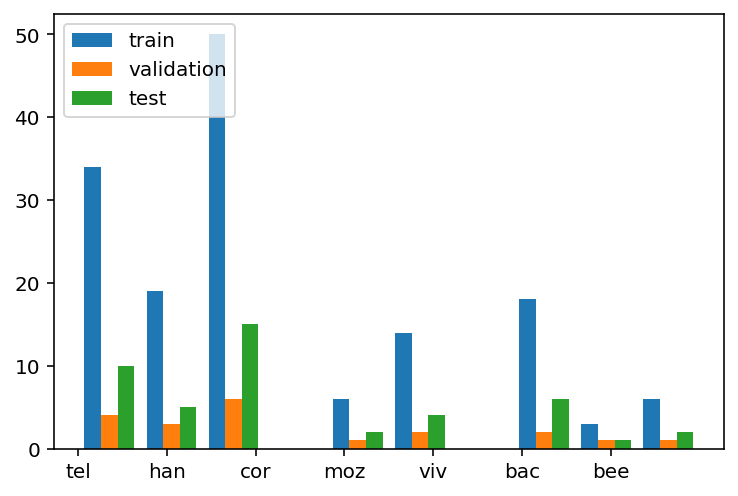

In [ ]:
# print the distribution of composers in train, test and validation
# ks_list = [m21.corpus.parse(p).parts[0].flat.getElementsByClass(m21.key.KeySignature)[0] for p  in path_validation]
composers = list(set([p.split("\\")[-1][:3] for p in paths ]))
print(composers)

train_composer = [composers.index(p.split("\\")[-1][:3]) for p in path_train]
val_composer = [composers.index(p.split("\\")[-1][:3]) for p in path_validation]
test_composer = [composers.index(p.split("\\")[-1][:3]) for p in path_test]

_ = plt.hist([train_composer, val_composer,test_composer], label=['train', 'validation', 'test'])
_ = plt.legend(loc='upper left')
_ = plt.xticks(list(range(7)), composers)

In [ ]:
# PAD = "<PAD>"

# tag_to_ix = {p: diatonic_pitches.index(p) for p in diatonic_pitches}
# #add PADDING TAD
# tag_to_ix[PAD] = len(diatonic_pitches)

# midi_to_ix = {m: m for m in range(12)}
# # #add PADDING TAD
# # midi_to_ix[PAD] = 12

# print(midi_to_ix[1])
# print(len(midi_to_ix))


# class Pitch2Diatonic():
#   def __call__(self, in_seq):
#     return [p[0] for p in in_seq]

# class Diatonic2Int():
#   def __call__(self, in_seq):
#     idxs = [tag_to_ix[w] for w in in_seq]
#     return idxs

# class Int2Pitch():
#   def __call__(self, in_seq):
#     return [accepted_pitches[i] for i in in_seq]

# class OneHotEncoder():
#     def __init__(self, alphabet_len):
#         self.alphabet_len = alphabet_len
        
#     def __call__(self, sample):
#         onehot = np.zeros([len(sample), self.alphabet_len])
#         tot_chars = len(sample)
#         onehot[np.arange(tot_chars), sample] = 1
#         return onehot
        
# class ToTensorFloat():
#   def __call__(self, sample):
#     return torch.tensor(sample,dtype=torch.float)

# class ToTensorLong():
#   def __call__(self, sample):
#     return torch.tensor(sample,dtype=torch.long)

1
12


In [ ]:
# pitches_len = len(diatonic_pitches)
# midinote_len = 12

# ### Define the preprocessing pipeline
# transform_diat = transforms.Compose([
#                                      Pitch2Diatonic(),
#                                      Diatonic2Int(),
#                                      ToTensorLong()])
# transform_chrom = transforms.Compose([
#                                       OneHotEncoder(len(midi_to_ix)),
#                                       ToTensorFloat()])

In [ ]:
PAD = "<PAD>"

tag_to_ix = {p: accepted_pitches.index(p) for p in accepted_pitches}
#add PADDING TAD
tag_to_ix[PAD] = len(accepted_pitches)

midi_to_ix = {m: m for m in range(12)}
# #add PADDING TAD
# midi_to_ix[PAD] = 12

print(midi_to_ix[1])
print(len(midi_to_ix))


class Pitch2Diatonic():
  def __call__(self, in_seq):
    return [p for p in in_seq]

class Diatonic2Int():
  def __call__(self, in_seq):
    idxs = [tag_to_ix[w] for w in in_seq]
    return idxs

class Int2Pitch():
  def __call__(self, in_seq):
    return [accepted_pitches[i] for i in in_seq]

class OneHotEncoder():
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample):
        onehot = np.zeros([len(sample), self.alphabet_len])
        tot_chars = len(sample)
        onehot[np.arange(tot_chars), sample] = 1
        return onehot
        
class ToTensorFloat():
  def __call__(self, sample):
    return torch.tensor(sample,dtype=torch.float)

class ToTensorLong():
  def __call__(self, sample):
    return torch.tensor(sample,dtype=torch.long)


pitches_len = len(accepted_pitches)
midinote_len = 12

### Define the preprocessing pipeline
transform_diat = transforms.Compose([
                                     Pitch2Diatonic(),
                                     Diatonic2Int(),
                                     ToTensorLong()])
transform_chrom = transforms.Compose([
                                      OneHotEncoder(len(midi_to_ix)),
                                      ToTensorFloat()])

1
12


In [ ]:
# ['onset', 'duration', 'pitches', 'midi_number', 'transposed_of', 'key_signature', 'original_ks', 'original_path']

class PSDataset(Dataset):
    def __init__(self, dict_dataset, paths, transf_c, transf_d, augment_dataset, truncate = None):
        if augment_dataset:
            self.chromatic_sequences = [e["midi_number"] for e in dict_dataset if e["original_path"] in paths]
            self.diatonic_sequences = [e["pitches"]
                                       for e in dict_dataset 
                                       if e["original_path"] in paths]
        else: #consider only non transposed pieces
            self.chromatic_sequences = [e["midi_number"] for e in dict_dataset 
                                        if (e["original_path"] in paths and e["transposed_of"]=="P1")]
            self.diatonic_sequences = [e["pitches"]
                                       for e in dict_dataset 
                                       if (e["original_path"] in paths and e["transposed_of"]=="P1")]
        #the transformations to apply to data
        self.transf_c = transf_c
        self.transf_d = transf_d
        self.truncate = truncate

    def __len__(self):
        return len(self.chromatic_sequences)

    def __getitem__(self, idx):
        chromatic_seq = self.chromatic_sequences[idx]
        diatonic_seq = self.diatonic_sequences[idx]
        

        #transform
        chromatic_seq = self.transf_c(chromatic_seq)
        diatonic_seq = self.transf_d(diatonic_seq)

        if not self.truncate is None:
            chromatic_seq = chromatic_seq[0:self.truncate]
            diatonic_seq = diatonic_seq[0:self.truncate]

        #sanity check
        assert len(chromatic_seq) == len(diatonic_seq)
        seq_len = len(diatonic_seq)
        
        return chromatic_seq, diatonic_seq, seq_len

train_dataset = PSDataset(mdata_dict_dataset,path_train, transform_chrom,transform_diat,True)
validation_dataset = PSDataset(mdata_dict_dataset,path_validation, transform_chrom,transform_diat, False)
test_dataset = PSDataset(mdata_dict_dataset,path_test, transform_chrom,transform_diat, False)

print(len(train_dataset),len(validation_dataset),len(test_dataset))



# test if it works
chrom, diat, l = next(iter(train_dataset))
print([[i for i, j in enumerate(m) if j == 1][0] for m in chrom[0:30]])
# print([diatonic_pitches[p.item()] for p in diat[0:30]])
print([accepted_pitches[p.item()] for p in diat[0:30]])

1800 20 45
[7, 7, 11, 2, 7, 2, 2, 6, 9, 7, 11, 7, 9, 11, 2, 2, 6, 9, 11, 2, 9, 0, 7, 2, 7, 11, 2, 2, 6, 9]
['G', 'G', 'B', 'D', 'G', 'D', 'D', 'F#', 'A', 'G', 'B', 'G', 'A', 'B', 'D', 'D', 'F#', 'A', 'B', 'D', 'A', 'C', 'G', 'D', 'G', 'B', 'D', 'D', 'F#', 'A']


In [ ]:
def pad_collate(batch):
    (xx, yy, l) = zip(*batch)
    
    xx_pad = pad_sequence(xx)
    yy_pad = pad_sequence(yy, padding_value=tag_to_ix[PAD])

    #sort the sequences by length
    seq_lengths, perm_idx = torch.Tensor(l).sort(0, descending=True)
    xx_pad = xx_pad[:,perm_idx,:]
    yy_pad = yy_pad[:,perm_idx]

    return xx_pad, yy_pad, seq_lengths

data_loader = DataLoader(dataset=validation_dataset, batch_size=4, shuffle=True, collate_fn=pad_collate)

#something is wrong here looking at the output


#test if it work
for batch in data_loader:
    print(batch[0].shape,batch[1].shape,batch[2])
    print(batch[1])
    break


torch.Size([569, 4, 12]) torch.Size([569, 4]) tensor([569., 496., 489., 162.])
tensor([[30,  6, 30,  6],
        [30,  6, 30,  6],
        [30,  6,  6, 15],
        ...,
        [ 0, 35, 35, 35],
        [30, 35, 35, 35],
        [30, 35, 35, 35]])


# Model Definition

In [ ]:
class RNNCRFTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_labels,n_layers =1):
        super(RNNCRFTagger,self).__init__()    
        
        self.n_labels = n_labels
        self.hidden_dim = hidden_dim

        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim //2, 
                          bidirectional=True, num_layers=n_layers)

        self.top_layer = nn.Linear(hidden_dim, self.n_labels)
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences,sentences_len):
        ## should I initialize here??
        sentences = torch.nn.utils.rnn.pack_padded_sequence(sentences, sentences_len)
        rnn_out, _ = self.rnn(sentences)
        rnn_out,_ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out)

        out = self.top_layer(rnn_out)
      
        return out
                
    def forward(self, sentences, labels, sentences_len):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences,sentences_len)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.

        # pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = pad_mask.byte().to(device)
        return -self.crf(scores, labels, mask = pad_mask )
            
    def predict(self, sentences,sentences_len):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences,sentences_len)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        pad_mask = torch.arange(max(sentences_len))[:, None] < sentences_len[None, :]
        pad_mask = pad_mask.byte().to(device)
        return self.crf.decode(scores,mask = pad_mask)

In [ ]:
sen_len = torch.Tensor([3,4,5])
m = torch.arange(torch.max(sen_len))[:, None] < sen_len[None, :]
print(m.byte())
print(m.shape)
torch.tensor([[1, 1], [1, 1], [1, 0]], dtype=torch.uint8)
print(len(tag_to_ix))

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [0, 0, 1]], dtype=torch.uint8)
torch.Size([5, 3])
36


Initialize model and optimizer for training

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

HIDDEN_DIM = 48
LEARNING_WEIGHT = 5e-2
WEIGHT_DECAY = 1e-4

model = RNNCRFTagger(12,HIDDEN_DIM,len(tag_to_ix), n_layers =1)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_WEIGHT, weight_decay=WEIGHT_DECAY)

Training device: cuda


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, collate_fn=pad_collate)

# Check predictions before training
with torch.no_grad(): # Disable gradient tracking
    for seq, targets,seq_len in train_dataloader:
        print("Loop shapes", seq.shape,targets.shape,seq_len.shape)
        seq = seq.to(device)
        targets = targets.to(device)
        # Forward pass
        loss =  model(seq, targets,seq_len)
        predicted = model.predict(seq,seq_len)
        print("len Predicted", len(predicted))
        for i,p in enumerate(predicted):
            gtruth =  list(targets[:,i].cpu())
            print('Prediction:   ',len(p), [diatonic_pitches[idx] for idx in p])
            print('Ground truth: ',len(gtruth), [diatonic_pitches[idx] for idx in gtruth[:len(p)]])
        break

Loop shapes torch.Size([445, 4, 12]) torch.Size([445, 4]) torch.Size([4])
len Predicted 4
Prediction:    445 ['C', 'G', 'B', 'C', 'G', 'B', 'C', 'C', 'C', 'G', 'C', 'C', 'G', 'C', 'C', 'C', 'A', 'C', 'G', 'B', 'C', 'A', 'C', 'G', 'B', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'C', 'C', 'C', 'C', 'C', 'G', 'C', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'C', 'G', 'B', 'C', 'B', 'C', 'G', 'B', 'C', 'C', 'C', 'G', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'C', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'G', 'B', 'C', 'C', 'G', 'C', 'G', 'C', 'C', 'C', 'G', 'B', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'B', 'C', 'B', 'C', 'C', 'C', 'C', 'G', 'B', 'C', 'C', 'G', 'C', 'G', 'C', 'C', 'C', 'G', 'B', 'C', 'G', 'B', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'G', 'B', 'C', 'G', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'C', 'G', 'C', 'G', 'B', 'C', 'G', 'B', 'C', 'C', 'G', 'C', 'G', 'C', 'C', 'G', 'B', 'C', 'C', 'G', 'C', 

### Train model

In [ ]:
def training_loop(model, optimizer, train_dataloader, val_dataloader, n_epochs):
    history = defaultdict(list)  
    for i_epoch in range(1,n_epochs +1):
        t0 = time.time()
        loss_sum = 0
        accuracy_sum = 0
        model.train()
        for seqs, targets, lens in train_dataloader: #seqs, targets, lens are batches
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()

            loss = model(seqs,targets,lens) / sum(lens) #normalize for the number of symbol considered (without padding)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

            predicted = model.predict(seqs,lens)
            for i,p in enumerate(predicted):
                acc= accuracy_score(p,targets[:,i][:len(p)].cpu()) #compute the accuracy without considering the padding
                accuracy_sum += acc/len(lens) #normalize according to the number of sequences in the batch

        train_loss = loss_sum/len(train_dataloader)
        train_accuracy = accuracy_sum/len(train_dataloader) #normalize according to the number of batches
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)


        # Evaluate on the validation set.
        model.eval()
        all_predicted = []
        all_targets = []
        with torch.no_grad():
            for seqs,targets, lens in val_dataloader:
                # Predict the model's output on a batch.
                predicted = model.predict(seqs.to(device),lens)                   
                # Update the evaluation statistics.
                for i,p in enumerate(predicted):
                    all_predicted.append(torch.Tensor(p))
                    all_targets.append(targets[0:int(lens[i]),i])
                
        # Compute the overall accuracy for the validation set
        val_accuracy = accuracy_score(torch.cat(all_predicted),torch.cat(all_targets))
        history["val_accuracy"].append(val_accuracy)

    
        t1 = time.time()
        print(f'Epoch {i_epoch}: train loss = {train_loss:.4f}, train_accuracy: {train_accuracy:.4f},val_accuracy: {val_accuracy:.4f}, time = {t1-t0:.4f}')
    return history

Training device: cuda
Epoch 1: train loss = 2.9843, train_accuracy: 0.2918,val_accuracy: 0.4561, time = 11.9331
Epoch 2: train loss = 2.3145, train_accuracy: 0.6304,val_accuracy: 0.8068, time = 11.9037
Epoch 3: train loss = 1.4244, train_accuracy: 0.8232,val_accuracy: 0.9682, time = 11.9370
Epoch 4: train loss = 0.7106, train_accuracy: 0.8811,val_accuracy: 0.9596, time = 11.8321
Epoch 5: train loss = 0.4428, train_accuracy: 0.9018,val_accuracy: 0.9849, time = 11.9048
Epoch 6: train loss = 0.3376, train_accuracy: 0.9198,val_accuracy: 0.9778, time = 11.7779
Epoch 7: train loss = 0.2771, train_accuracy: 0.9314,val_accuracy: 0.9828, time = 11.7947
Epoch 8: train loss = 0.2457, train_accuracy: 0.9341,val_accuracy: 0.8607, time = 11.9318
Epoch 9: train loss = 0.2196, train_accuracy: 0.9436,val_accuracy: 0.9864, time = 11.8047
Epoch 10: train loss = 0.1886, train_accuracy: 0.9481,val_accuracy: 0.9859, time = 11.7353
Epoch 11: train loss = 0.1920, train_accuracy: 0.9460,val_accuracy: 0.9778, t

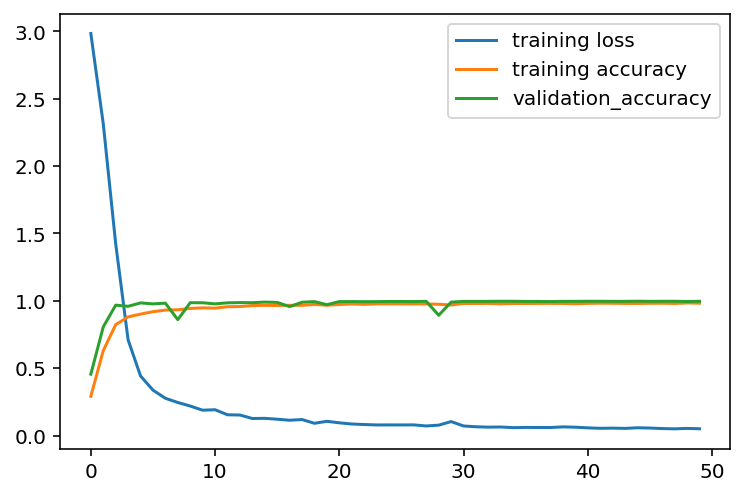

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

n_epochs = 50
HIDDEN_DIM = 72
LEARNING_WEIGHT = 5e-1
WEIGHT_DECAY = 1e-4

train_dataset = PSDataset(mdata_dict_dataset,path_train, transform_chrom,transform_diat,True, truncate = 100)
validation_dataset = PSDataset(mdata_dict_dataset,path_validation, transform_chrom,transform_diat, False, truncate= 100)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=pad_collate)
val_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True,collate_fn=pad_collate)

model = RNNCRFTagger(12,HIDDEN_DIM,len(tag_to_ix), n_layers =1)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_WEIGHT, weight_decay=WEIGHT_DECAY)
# otimizer = torch.optim.Adam(model.parameters(),lr = 0.05, weight_decay=1e-4)

history = training_loop(model,optimizer,train_dataloader,val_dataloader, n_epochs)

# After the final evaluation, we print more detailed evaluation statistics,
plt.plot(history['train_loss'])
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['training loss', 'training accuracy', 'validation_accuracy'])

In [ ]:
torch.save(model, "model_crf100.pkl")
files.download("model_crf100.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#test the network
test_dataset = PSDataset(mdata_dict_dataset,path_test, transform_chrom,transform_diat, False)
test_dataloader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, collate_fn=pad_collate)

all_inputs = []
all_predicted = []
all_targets = []
model.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for seqs, targets,lens in test_dataloader:
        seqs = seq.to(device)

        # Predict the model's output on a batch.
        predicted = model.predict(seqs,lens)                   
        # Update the evaluation statistics.
        for i,p in enumerate(predicted):
            all_predicted.append(torch.Tensor(p))
            all_targets.append(targets[0:int(lens[i]),i])
    
# Concatenate all the outputs and labels ina single tensor
# all_inputs  = torch.cat(all_inputs)|
all_predicted = torch.cat(all_predicted)
all_targets  = torch.cat(all_targets)

predicted_pitches = all_predicted.cpu()
test_targets = all_targets.cpu()

correct = (predicted_pitches == test_targets).sum().item()
acc = correct/test_targets.size(0)

print("Test accuracy:", acc )

Test accuracy: 0.9963669169999024


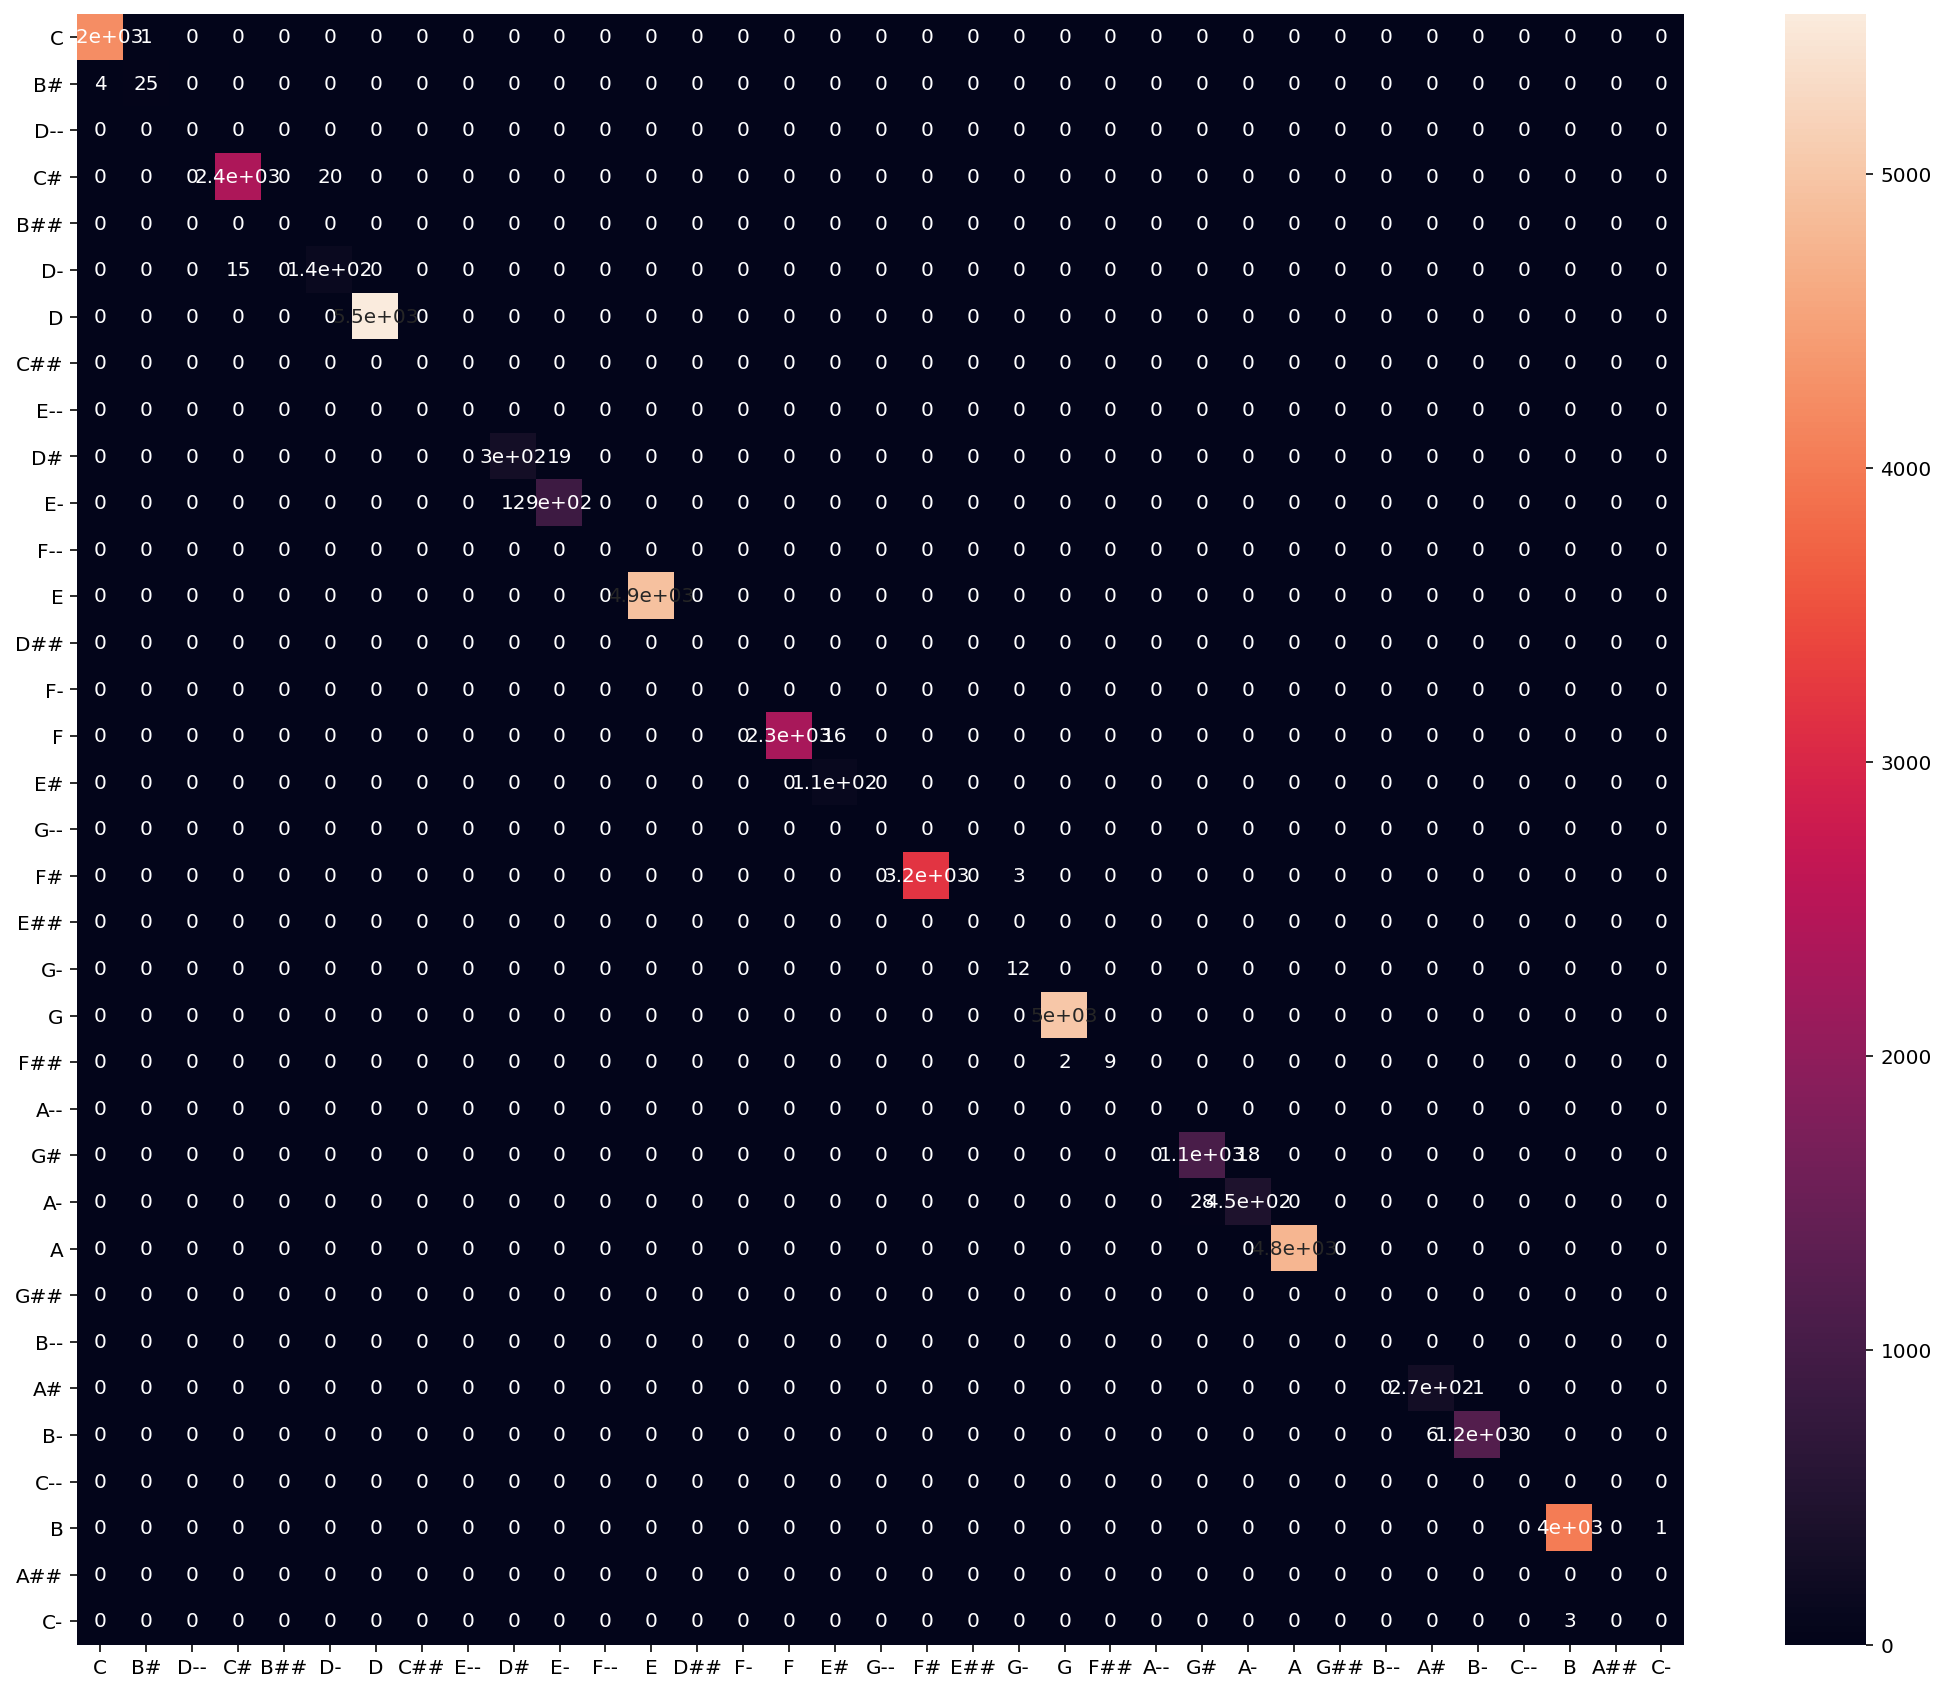

In [ ]:
cf_matrix = confusion_matrix(test_targets, predicted_pitches, labels= range(len(accepted_pitches)), normalize=None)

import seaborn as sns
ax_labels = accepted_pitches
plt.figure(figsize=(18,15))
sns.heatmap(cf_matrix, xticklabels=ax_labels, yticklabels=ax_labels, annot=True)

In [ ]:
# look at real pieces part 2

pieces = []
with torch.no_grad():
    for index, (seqs, targets, lens) in enumerate(test_dataloader):
        seqs = seqs.to(device)
        # Predict the model's output on a batch.
        predicted = model.predict(seqs,lens)                   
        # Update the evaluation statistics.
        for i,p in enumerate(predicted):
            piece_midi_input = seqs[0:int(lens[i]),i,:].cpu()
            piece_predicted = torch.Tensor(p)
            piece_targets = targets[0:int(lens[i]),i]

            correct = (torch.Tensor(piece_predicted) == piece_targets).sum().item()
            acc_seq = correct/piece_targets.size(0)
            pieces.append({"accuracy":acc_seq, 
                        "midi_notes": torch.argmax(piece_midi_input,1).numpy(),
                        "pred_pitches" :[accepted_pitches[int(p)] for p in piece_predicted],
                        "true_pitches" : [accepted_pitches[int(p)] for p in piece_targets]})

In [ ]:
worst_acc_index = np.argmin([p["accuracy"] for p in pieces])
worst_piece = pieces[worst_acc_index]
print("Acc:", worst_piece["accuracy"])
for e in zip(worst_piece["midi_notes"],worst_piece["pred_pitches"],worst_piece["true_pitches"]):
    if e[1] == e[2]:
        print(e)
    else:
        print(e, "!")

Acc: 0.9745222929936306
(7, 'G', 'G')
(4, 'E', 'E')
(0, 'C', 'C')
(7, 'G', 'G')
(4, 'E', 'E')
(4, 'E', 'E')
(0, 'C', 'C')
(4, 'E', 'E')
(7, 'G', 'G')
(0, 'C', 'C')
(4, 'E', 'E')
(7, 'G', 'G')
(0, 'C', 'C')
(4, 'E', 'E')
(9, 'A', 'A')
(2, 'D', 'D')
(6, 'F#', 'F#')
(0, 'C', 'C')
(9, 'A', 'A')
(2, 'D', 'D')
(6, 'F#', 'F#')
(0, 'C', 'C')
(7, 'G', 'G')
(7, 'G', 'G')
(11, 'B', 'B')
(0, 'C', 'C')
(2, 'D', 'D')
(6, 'F#', 'F#')
(9, 'A', 'A')
(11, 'B', 'B')
(2, 'D', 'D')
(7, 'G', 'G')
(7, 'G', 'G')
(0, 'C', 'C')
(4, 'E', 'E')
(10, 'B-', 'B-')
(7, 'G', 'G')
(0, 'C', 'C')
(4, 'E', 'E')
(10, 'B-', 'B-')
(5, 'F', 'F')
(5, 'F', 'F')
(9, 'A', 'A')
(10, 'B-', 'B-')
(0, 'C', 'C')
(4, 'E', 'E')
(7, 'G', 'G')
(9, 'A', 'A')
(0, 'C', 'C')
(5, 'F', 'F')
(5, 'F', 'F')
(9, 'A', 'A')
(0, 'C', 'C')
(9, 'A', 'A')
(7, 'G', 'G')
(7, 'G', 'G')
(0, 'C', 'C')
(4, 'E', 'E')
(5, 'F', 'F')
(2, 'D', 'D')
(5, 'F', 'F')
(11, 'B', 'B')
(2, 'D', 'D')
(0, 'C', 'C')
(4, 'E', 'E')
(0, 'C', 'C')
(0, 'C', 'C')
(11, 'B', 'B')
(2, '

# Test on the entire corpus

In [ ]:
full_dataset = PSDataset(mdata_dict_dataset,paths, transform_chrom,transform_diat,False)
full_dataloader  = DataLoader(full_dataset,  batch_size=64, shuffle=False, collate_fn=pad_collate)

In [ ]:
all_inputs = []
all_outputs = []
all_targets = []
model.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for seqs, targets,lens in full_dataloader:
    # Move data to device
    seqs = seqs.to(device)

    # Predict the model's output on a batch.
    predicted = model.predict(seqs,lens)                   
    # Update the evaluation statistics.
    for i,p in enumerate(predicted):
        all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
        all_outputs.append(torch.Tensor(p))
        all_targets.append(targets[0:int(lens[i]),i])

print()

In [ ]:
list(all_inputs[3])

[2,
 9,
 2,
 6,
 9,
 9,
 9,
 2,
 6,
 2,
 9,
 9,
 2,
 6,
 9,
 9,
 6,
 9,
 1,
 7,
 6,
 9,
 9,
 4,
 2,
 2,
 6,
 2,
 9,
 9,
 2,
 6,
 9,
 9,
 2,
 2,
 6,
 9,
 9,
 9,
 2,
 6,
 9,
 9,
 2,
 2,
 6,
 6,
 9,
 9,
 9,
 9,
 1,
 4,
 9,
 9,
 9,
 7,
 2,
 2,
 6,
 6,
 9,
 9,
 2,
 6,
 9,
 9,
 9,
 1,
 4,
 4,
 9,
 9,
 1,
 4,
 9,
 9,
 9,
 2,
 6,
 6,
 9,
 9,
 9,
 1,
 4,
 4,
 9,
 9,
 1,
 4,
 9,
 9,
 9,
 2,
 6,
 11,
 2,
 11,
 2,
 6,
 6,
 4,
 9,
 1,
 9,
 1,
 4,
 4,
 9,
 1,
 1,
 4,
 4,
 8,
 2,
 11,
 11,
 4,
 9,
 9,
 9,
 1,
 9,
 7,
 11,
 6,
 9,
 4,
 7,
 2,
 6,
 1,
 4,
 2,
 2,
 6,
 9,
 2,
 6,
 9,
 9,
 9,
 9,
 6,
 2,
 6,
 2,
 9,
 9,
 2,
 2,
 2,
 6,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 1,
 6,
 7,
 6,
 9,
 4,
 9,
 4,
 2,
 2,
 6,
 2,
 6,
 2,
 9,
 9,
 2,
 6,
 9,
 9,
 2,
 2,
 6,
 9,
 2,
 6,
 9,
 6,
 9,
 9,
 9,
 2,
 6,
 9,
 2,
 9,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 6,
 9,
 6,
 9,
 6,
 9,
 9,
 9,
 1,
 4,
 9,
 4,
 9,
 9,
 7,
 9,
 7,
 2,
 2,
 2,
 6,
 2,
 6,
 9,
 9,
 2,
 6,
 9,
 9,
 9,
 9,
 1,
 4,
 1,
 4,
 9,
 9,
 1,
 4,
 9,
 9,
 9,
 2,
 6,

In [ ]:
# Divide accuracy according to author
authors = []

for sequence in all_inputs:
    author = [e["original_path"].split("\\")[-1][:3] for e in mdata_dict_dataset 
              if len(e["midi_number"]) == len(sequence) and
              list(e["midi_number"]) ==list(sequence) ]
    # assert len(author) == 1
    authors.append(author[0])

considered_authors = list(set(authors))
print(considered_authors)

['tel', 'han', 'cor', 'moz', 'viv', 'bac', 'bee', 'hay']


In [ ]:
errors_per_author = {}
accuracy_per_author = {}
for ca in considered_authors:
    # ca_inputs = torch.cat([all_inputs[i] for i,a in enumerate(authors) if a == ca])
    ca_outputs = torch.cat([all_outputs[i] for i,a in enumerate(authors) if a == ca])
    ca_targets = torch.cat([all_targets[i] for i,a in enumerate(authors) if a == ca])
    # print(ca_inputs.shape,ca_outputs.shape,ca_targets.shape,ca_predicted_pitches.shape)
    ca_acc = accuracy_score(ca_outputs,ca_targets)
    accuracy_per_author[ca] = float(ca_acc)
    errors_per_author[ca] = int(len(ca_targets) - sum(torch.eq(ca_outputs,ca_targets)))

print(errors_per_author)
print(accuracy_per_author)

{'tel': 34, 'han': 26, 'cor': 5, 'moz': 120, 'viv': 81, 'bac': 53, 'bee': 340, 'hay': 243}
{'tel': 0.9986122448979592, 'han': 0.998938775510204, 'cor': 0.9997958600416446, 'moz': 0.9951008410222911, 'viv': 0.9966934726701229, 'bac': 0.997837176086513, 'bee': 0.9861184828318295, 'hay': 0.9865790345741743}


In [ ]:
# Concatenate all the outputs and labels ina single tensor
# all_inputs  = torch.cat(all_inputs)
# all_outputs = torch.cat(all_outputs)
# all_targets  = torch.cat(all_targets)
print(type(all_outputs[0]))

predicted_pitches = torch.argmax(torch.cat(all_outputs), 1)
acc = accuracy_score(predicted_pitches,torch.cat(all_targets))

print("Test accuracy:", acc )

<class 'torch.Tensor'>
Test accuracy: 0.9950260565014664


# Test on ASAP

In [ ]:
!git clone https://github.com/fosfrancesco/asap-dataset.git

Cloning into 'asap-dataset'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 3167 (delta 20), reused 13 (delta 5), pack-reused 3129
Receiving objects: 100% (3167/3167), 64.04 MiB | 22.45 MiB/s, done.
Resolving deltas: 100% (300/300), done.
Checking out files: 100% (2781/2781), done.


In [ ]:
import pandas as pd
# load the bach dataset
df = pd.read_csv(Path('/content/asap-dataset/metadata.csv'))
df = df.drop_duplicates(subset=["title","composer"])

with open(Path('/content/asap-dataset/asap_annotations.json')) as json_file:
  json_data = json.load(json_file)

# accidentals_list = [list(json_data[m]["midi_score_key_signatures"].values())[0][1] for m  in df["midi_performance"]]
xml_score_path = list(df["xml_score"])

print("N of pieces: ", len(xml_score_path))

N of pieces:  222


In [ ]:
asap_dict_dataset = []

# ['onset', 'duration', 'pitches', 'midi_number', 'transposed_of', 'key_signature', 'original_ks', 'original_path']
for i,path in enumerate(xml_score_path):
    print("Processing", path)
    score = m21.converter.parse(str(Path('/content/asap-dataset',path)))
    asap_dict_dataset.append({
            'pitches': score2pitches(score),
            'midi_number' : score2midi_numbers(score),
            'original_path' : str(path),
            'transposed_of' : "P1"
        })

Processing Bach/Fugue/bwv_846/xml_score.musicxml
Processing Bach/Fugue/bwv_848/xml_score.musicxml
Processing Bach/Fugue/bwv_854/xml_score.musicxml
Processing Bach/Fugue/bwv_856/xml_score.musicxml
Processing Bach/Fugue/bwv_857/xml_score.musicxml
Processing Bach/Fugue/bwv_858/xml_score.musicxml
Processing Bach/Fugue/bwv_860/xml_score.musicxml
Processing Bach/Fugue/bwv_862/xml_score.musicxml
Processing Bach/Fugue/bwv_863/xml_score.musicxml
Processing Bach/Fugue/bwv_864/xml_score.musicxml
Processing Bach/Fugue/bwv_865/xml_score.musicxml
Processing Bach/Fugue/bwv_866/xml_score.musicxml
Processing Bach/Fugue/bwv_867/xml_score.musicxml
Processing Bach/Fugue/bwv_868/xml_score.musicxml
Processing Bach/Fugue/bwv_870/xml_score.musicxml
Processing Bach/Fugue/bwv_873/xml_score.musicxml
Processing Bach/Fugue/bwv_874/xml_score.musicxml
Processing Bach/Fugue/bwv_875/xml_score.musicxml
Processing Bach/Fugue/bwv_876/xml_score.musicxml
Processing Bach/Fugue/bwv_880/xml_score.musicxml
Processing Bach/Fugu

In [ ]:
torch.save(asap_dict_dataset, "asap_original_key.pkl")
files.download("asap_original_key.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(len(xml_score_path), "different pieces")
print("Average number of notes: ", np.mean([len(e["midi_number"]) for e in asap_dict_dataset ]))

222 different pieces
Average number of notes:  2726.9054054054054


In [ ]:
asap_dataset = PSDataset(asap_dict_dataset,xml_score_path, transform_chrom,transform_diat,False)
asap_dataloader  = DataLoader(asap_dataset,  batch_size=64, shuffle=False, collate_fn=pad_collate)

all_inputs = []
all_outputs = []
all_targets = []
model.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for seqs, targets,lens in asap_dataloader:
    # Move data to device
    seqs = seqs.to(device)

    # Predict the model's output on a batch.
    predicted = model.predict(seqs,lens)                   
    # Update the evaluation statistics.
    for i,p in enumerate(predicted):
        all_inputs.append(torch.argmax(seqs[0:int(lens[i]),i,:].cpu(),1).numpy())
        all_outputs.append(torch.Tensor(p))
        all_targets.append(targets[0:int(lens[i]),i])

In [ ]:
# Divide accuracy according to author
authors = []

for sequence in all_inputs:
    author = [e["original_path"].split("\\")[-1][:3] for e in asap_dict_dataset 
              if len(e["midi_number"]) == len(sequence) and
              list(e["midi_number"]) ==list(sequence) ]
    # assert len(author) == 1
    authors.append(author[0])

considered_authors = list(set(authors))
print(considered_authors)

['Cho', 'Sch', 'Lis', 'Moz', 'Rav', 'Bal', 'Bee', 'Bac', 'Hay', 'Bra', 'Deb', 'Scr', 'Pro', 'Gli', 'Rac']


In [ ]:
errors_per_author = {}
accuracy_per_author = {}
for ca in considered_authors:
    # ca_inputs = torch.cat([all_inputs[i] for i,a in enumerate(authors) if a == ca])
    ca_outputs = torch.cat([all_outputs[i] for i,a in enumerate(authors) if a == ca])
    ca_targets = torch.cat([all_targets[i] for i,a in enumerate(authors) if a == ca])
    # print(ca_inputs.shape,ca_outputs.shape,ca_targets.shape,ca_predicted_pitches.shape)
    ca_acc = accuracy_score(ca_outputs,ca_targets)
    accuracy_per_author[ca] = float(ca_acc)
    errors_per_author[ca] = int(len(ca_targets) - sum(torch.eq(ca_outputs,ca_targets)))

print(errors_per_author)
print(accuracy_per_author)

{'Cho': 9459, 'Sch': 8371, 'Lis': 15951, 'Moz': 261, 'Rav': 2686, 'Bal': 2558, 'Bee': 7794, 'Bac': 4337, 'Hay': 286, 'Bra': 120, 'Deb': 721, 'Scr': 1465, 'Pro': 556, 'Gli': 40, 'Rac': 94}
{'Cho': 0.9116707754370238, 'Sch': 0.8975573341165528, 'Lis': 0.8146267199702492, 'Moz': 0.9831471556789565, 'Rav': 0.8379096011103735, 'Bal': 0.6990942242089166, 'Bee': 0.9557824865968854, 'Bac': 0.9286125788026929, 'Hay': 0.9868505747126437, 'Bra': 0.9303135888501742, 'Deb': 0.8726373432255785, 'Scr': 0.8533093020927205, 'Pro': 0.8808401200171453, 'Gli': 0.9812909260991581, 'Rac': 0.9866135004272287}


In [ ]:
import music21 as m21
m21.__version__

'5.5.0'

In [ ]:
m21.converter.parse("/content/asap-dataset/Balakirev/Islamey/xml_score.musicxml")

<music21.stream.Score 0x7f5ed9c01390>